In [1]:
import sys
sys.path.append('../modules/')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pulp
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from mymodule_3 import *
from mymodule3_2 import *
from pulp_func_3 import *
df2023_result = pd.read_excel('../excels/附件3/2023_result.xlsx')
# 去除列名末尾的空格。很奇怪
df2023_result.columns = [column.rstrip(' ') for column in df2023_result.columns]
# print(df2023_result)

In [2]:
# 数据准备

merged_df = get_merged_df(df21, df22)
# print(merged_df)
total_yield_2023 = merged_df.groupby(['作物编号', '作物名称'])['单地块类型总产量/斤'].sum().reset_index()
total_yield_2023.columns = ['作物编号', '作物名称', '总产量/斤']
# print(total_yield_2023)
expected_sales_data_2023 = total_yield_2023.copy()
expected_sales_data_2023.columns = ['作物编号', '作物名称', '预期销售量/斤']

# 按照 '作物编号' 和 '作物名称' 进行分组，并对 '利润' 进行求和
total_profit = merged_df.groupby(['作物编号', '作物名称'])[['利润', '每亩利润']].sum().reset_index()
# 重命名列，以便清晰地表示数据
total_profit.columns = ['作物编号', '作物名称', '总利润/元', '每亩总利润/元']
# 打印 total_profit
# print(total_profit)
total_profit_2023 = total_profit['总利润/元'].sum()
# print("总利润/元的和:", total_profit_2023)
std_devs = [0.005, 0.005, 0.01, 0.01, 0.003, 0.003, 0.003, 0.003]
past_profits = [total_profit_2023]

fields = create_fields(df11)
# for field in fields:
#     print(field)
new_fields = create_new_fields(fields)
# for field in new_fields:
#     print(field)

In [3]:
expected_sales_data = total_yield_2023.copy() # 初始值为2023年的数据
expected_sales_data.columns = ['作物编号', '作物名称', '预期销售量/斤']
crops = create_crops(df12, df22)
# for crop in crops:
#     print(crop)
# 构建预期销售量矩阵
es_matrix = pd.DataFrame()
es_matrix['2023'] = expected_sales_data['预期销售量/斤']

# 构建销售价格矩阵
price_matrix = pd.DataFrame()
price_matrix['2023'] = [crop.crop_price for crop in crops]

# 构建种植成本矩阵
cost_matrix = pd.DataFrame()
cost_matrix['2023'] = [np.mean([field[3] for field in crop.planting_fields]) for crop in crops]

for year in range(2024, 2031):
    # 更新数据
    expected_sales_data = update_expected_sales_data(expected_sales_data, expected_sales_data_2023, std_devs)
    crops = update_crops(crops, std_devs)
       
    # 追加到预期销售量矩阵
    es_matrix[str(year)] = expected_sales_data['预期销售量/斤']
    # 追加到销售价格矩阵
    price_matrix[str(year)] = [crop.crop_price for crop in crops]
    # 追加到种植成本矩阵
    cost_matrix[str(year)] = [np.mean([field[3] for field in crop.planting_fields]) for crop in crops]

# 转置矩阵并设置列名
es_matrix = es_matrix.T
es_matrix.columns = expected_sales_data['作物名称'].values
es_matrix.columns = [column.rstrip(' ') for column in es_matrix.columns]
es_matrix_corr = es_matrix.corr()

price_matrix = price_matrix.T
price_matrix.columns = [crop.crop_name for crop in crops]

cost_matrix = cost_matrix.T
cost_matrix.columns = [crop.crop_name for crop in crops]

In [4]:
# 定义分类依据
categories = {
    '粮食': 'grain',
    '粮食（豆类）': 'grain_bean',
    '粮食（水稻）': 'grain_rice',
    '蔬菜': 'vegetable',
    '蔬菜（豆类）': 'vegetable_bean',
    '蔬菜（水二）': 'vegetable_water',
    '食用菌': 'mushroom'
}

# 初始化分类矩阵字典
es_matrices = {}
price_matrices = {}
cost_matrices = {}

# 使用循环进行分类
for crop_type, suffix in categories.items():
    es_matrices[suffix] = es_matrix[[crop.crop_name for crop in crops if crop.crop_type == crop_type]]
    price_matrices[suffix] = price_matrix[[crop.crop_name for crop in crops if crop.crop_type == crop_type]]
    cost_matrices[suffix] = cost_matrix[[crop.crop_name for crop in crops if crop.crop_type == crop_type]]

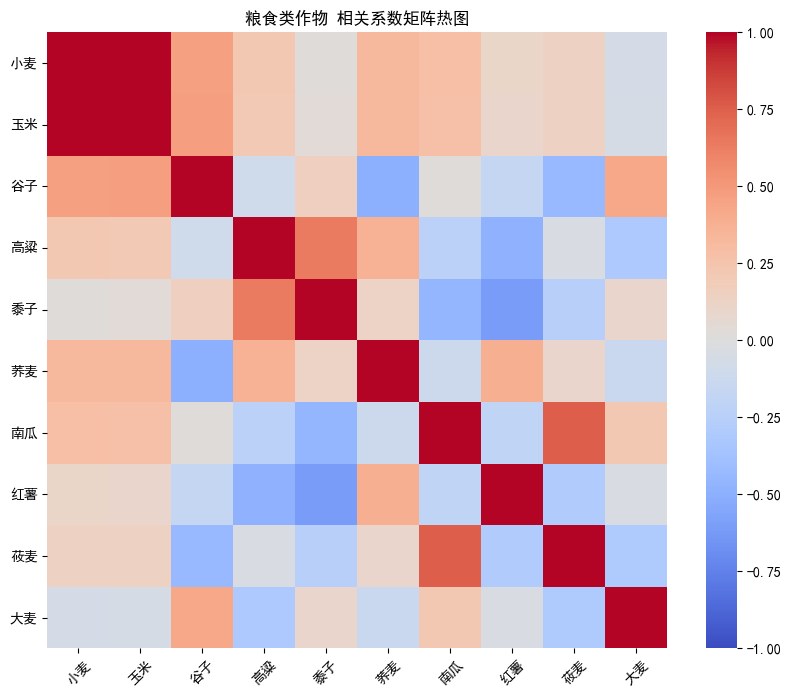

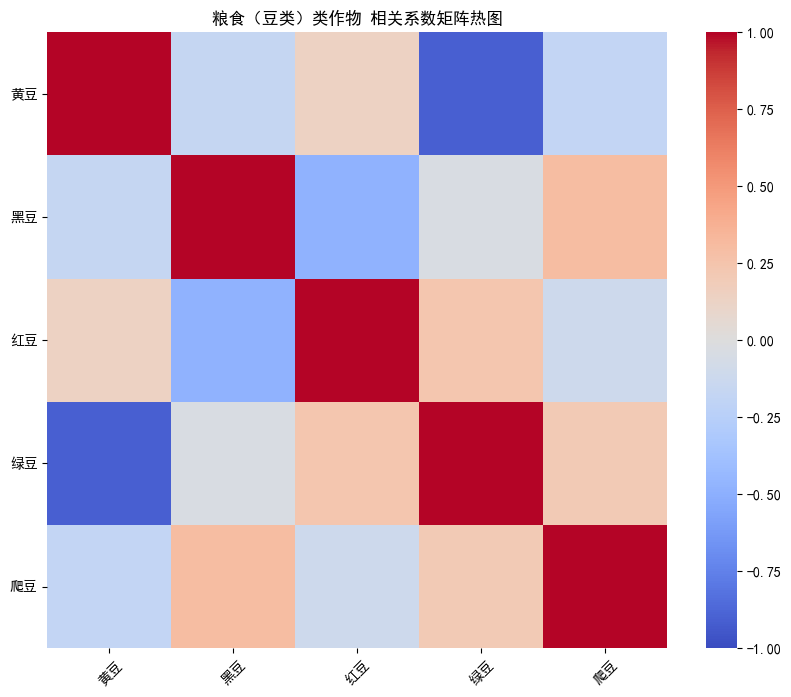

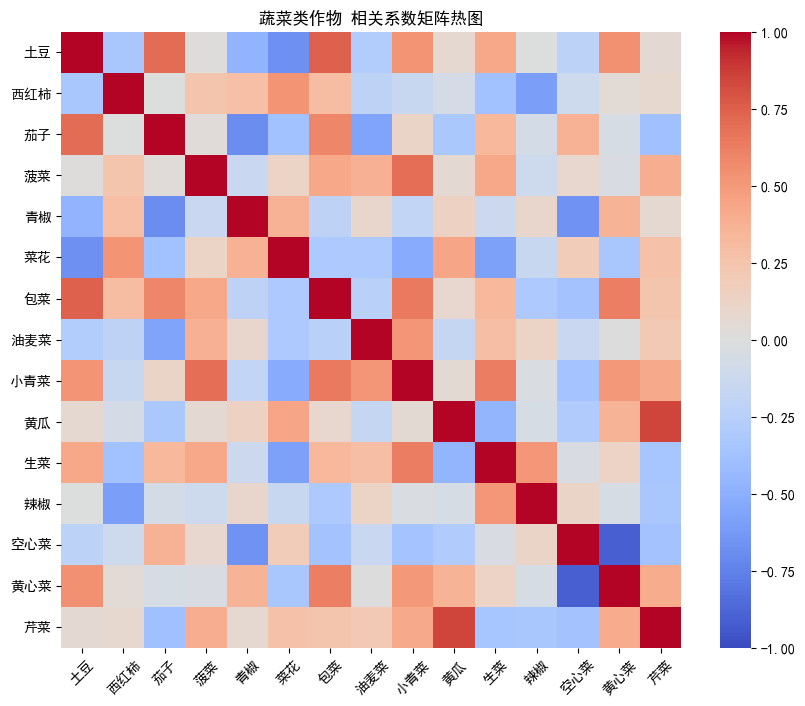

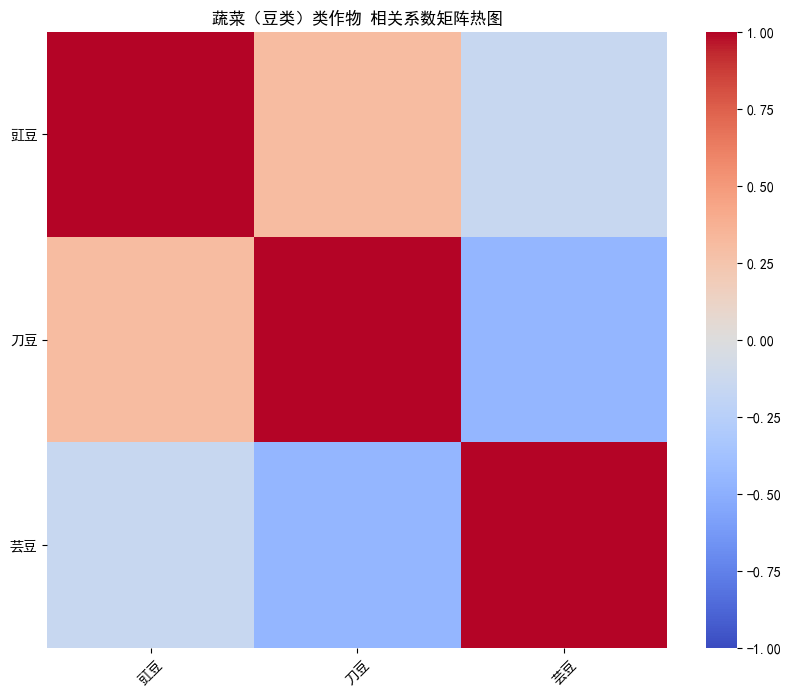

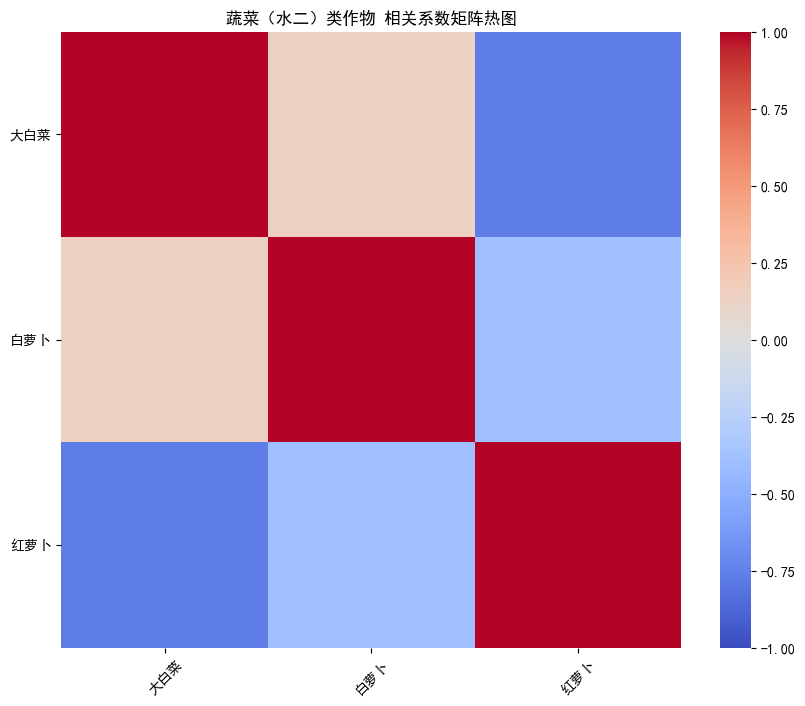

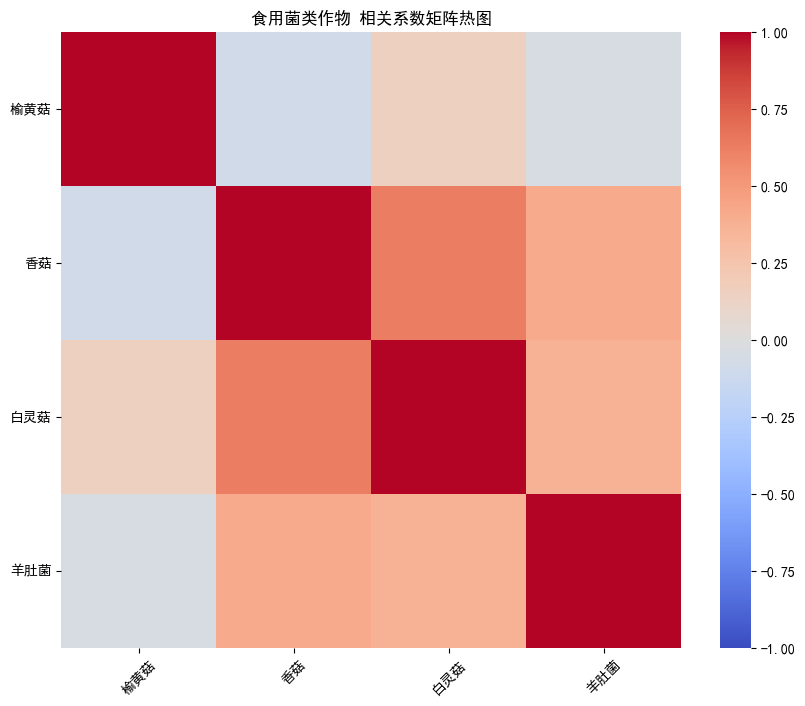

In [5]:
# 计算并绘制热图
def plot_heatmaps(matrix, title_prefix):
    corr_matrix = matrix.corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, cmap='coolwarm', cbar=True, vmin=-1, vmax=1)
    plt.title(f'{title_prefix} 相关系数矩阵热图')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.show()

# 使用循环绘制热图
for crop_type, suffix in categories.items():
    if suffix != 'grain_rice':
        plot_heatmaps(es_matrices[suffix], f'{crop_type}类作物')

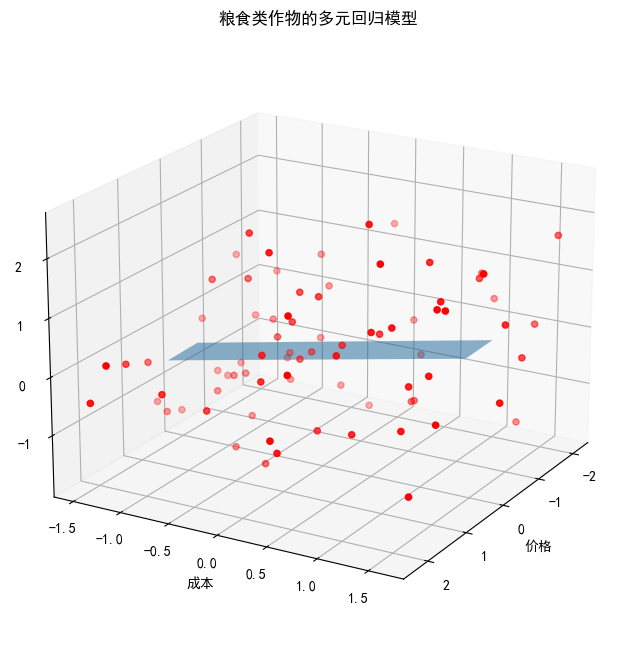

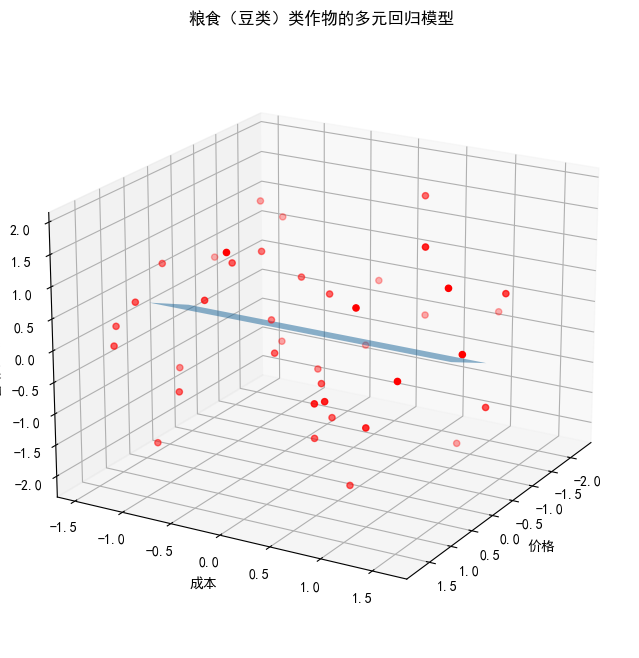

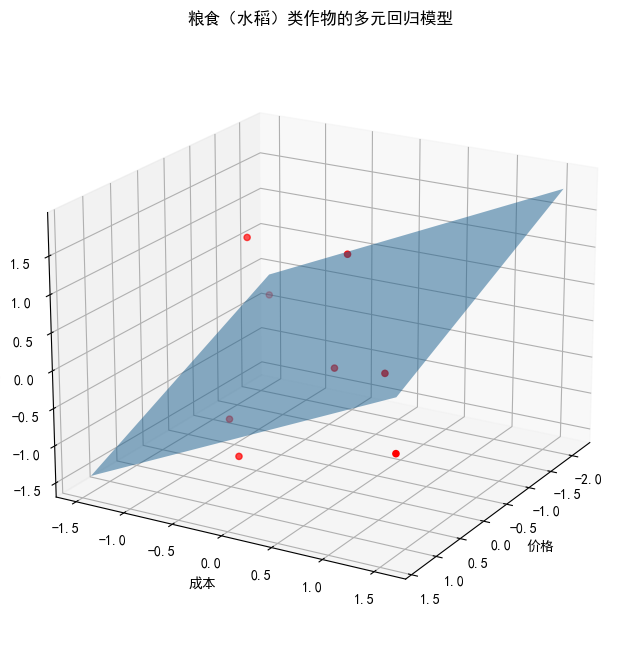

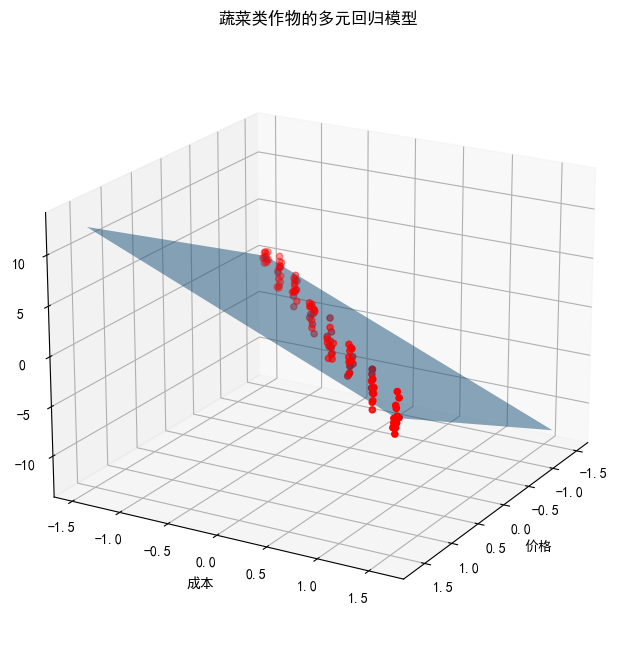

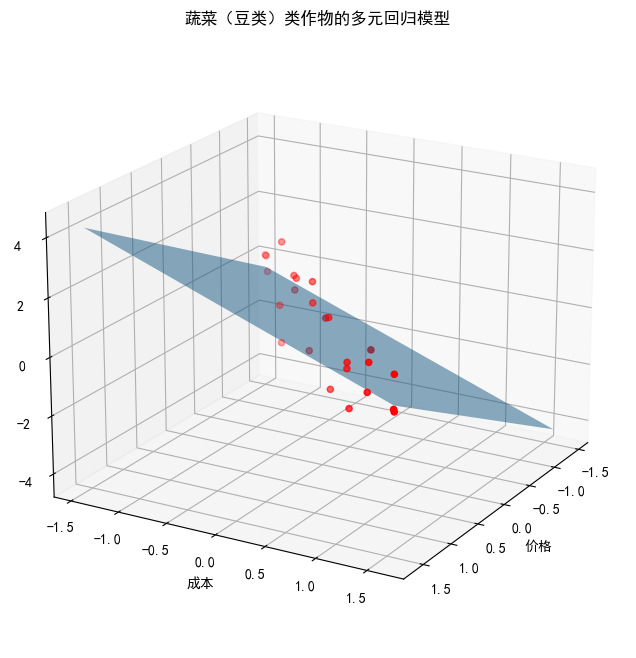

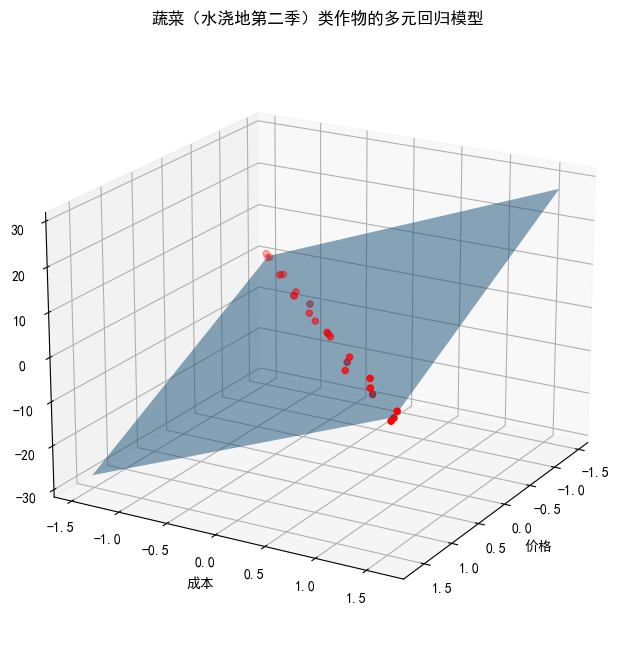

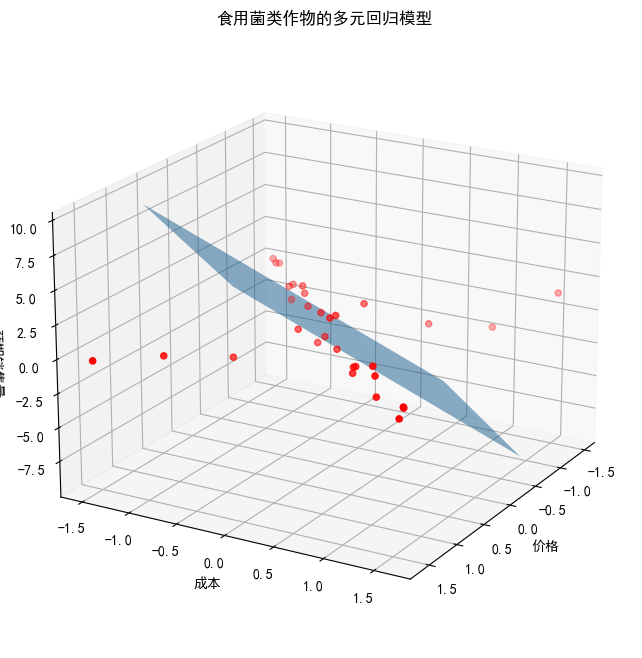

In [6]:
# 标准化处理
scaler = StandardScaler()
es_matrices_std = {}
price_matrices_std = {}
cost_matrices_std = {}

for suffix in categories.values():
    es_matrices_std[suffix] = pd.DataFrame(scaler.fit_transform(es_matrices[suffix]), index=es_matrices[suffix].index, columns=es_matrices[suffix].columns)
    price_matrices_std[suffix] = pd.DataFrame(scaler.fit_transform(price_matrices[suffix]), index=price_matrices[suffix].index, columns=price_matrices[suffix].columns)
    cost_matrices_std[suffix] = pd.DataFrame(scaler.fit_transform(cost_matrices[suffix]), index=cost_matrices[suffix].index, columns=cost_matrices[suffix].columns)

# 合成每一类的总体趋势数据
es_trends = {}
price_trends = {}
cost_trends = {}

for suffix in categories.values():
    es_trends[suffix] = es_matrices_std[suffix].mean(axis=1)
    price_trends[suffix] = price_matrices_std[suffix].mean(axis=1)
    cost_trends[suffix] = cost_matrices_std[suffix].mean(axis=1)

regression_params_dict = {}
# 构建多元回归模型并绘制三维图像
for crop_type, suffix in categories.items():
    # 准备数据
    X = pd.DataFrame({
        '价格': price_trends[suffix],
        '成本': cost_trends[suffix]
    })
    y = es_trends[suffix]
    
    # 添加常数项
    X = sm.add_constant(X)
    
    # 构建回归模型
    model = sm.OLS(y, X).fit()
    # 打包回归参数
    regression_params_dict[crop_type] = {
        'intercept': model.params[0],
        'price_coef': model.params[1],
        'cost_coef': model.params[2]
    }
    # 绘制三维图像
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # 使用标准化处理后的原始数据绘制散点图
    for i in range(es_matrices_std[suffix].shape[1]):
        ax.scatter(price_matrices_std[suffix].iloc[:, i], cost_matrices_std[suffix].iloc[:, i],
                   es_matrices_std[suffix].iloc[:, i], c='r', marker='o')
    
    # 创建网格以绘制回归平面
    xx, yy = np.meshgrid(np.linspace(X['价格'].min(), X['价格'].max(), 10), 
                         np.linspace(X['成本'].min(), X['成本'].max(), 10))
    zz = model.params[0] + model.params[1] * xx + model.params[2] * yy
    
    ax.plot_surface(xx, yy, zz, alpha=0.5, rstride=100, cstride=100)
    
    ax.set_xlabel('价格')
    ax.set_ylabel('成本')
    ax.set_zlabel('预期销售量')
    if crop_type != '蔬菜（水二）':
        ax.set_title(f'{crop_type}类作物的多元回归模型')
    else:
        ax.set_title(f'蔬菜（水浇地第二季）类作物的多元回归模型')
    
    # 调整视角以确保平面占据大部分画布
    ax.view_init(elev=20., azim=30)
    
    plt.show()

In [ ]:
mc = 8 # 蒙特卡洛模拟次数
weights = [0.7, 0.3] # 分数计算权重
k = 0.5
min_area_percent = 0.2
max_plots = 4
total_score_max = 0
total_score_i_list = []
scores_max = []
profits_max = []
total_profit_i_list = []
stability_max = []
total_stability_i_list = []
for i in range(mc): 
    # 每次蒙特卡洛模拟都要重新初始化数据
    df_template_list = []
    scores = [total_profit_2023, 0, 0, 0, 0, 0, 0, 0] # 2023年到2030年的得分
    profits = [total_profit_2023, 0, 0, 0, 0, 0, 0, 0] # 2023年到2030年的利润
    past_profits = [total_profit_2023] # 别忘了重置这个！其实这个和上面的profits是一样的，但已经这么设定了就不改了
    stabilitys = [0, 0, 0, 0, 0, 0, 0, 0] # 2023年到2030年的稳定性分数（其实是不稳定性）
    expected_sales_data = total_yield_2023.copy() # 初始值为2023年的数据
    expected_sales_data.columns = ['作物编号', '作物名称', '预期销售量/斤']
    crops = create_crops(df12, df22)
    # 2024年

    # 更新数据
    expected_sales_data = update_expected_sales_data(expected_sales_data, expected_sales_data_2023, std_devs)
    crops = update_crops(crops, std_devs)

    variables, binary_variables, actual_sales, excess_yield = create_variables(new_fields, crops)
    # 创建线性规划问题
    prob = pulp.LpProblem("Crop_Planting_Optimization", pulp.LpMaximize)
    # 定义目标函数的各个部分
    profit = define_objective_function(variables, actual_sales, excess_yield, crops, new_fields, k)
    # 将目标函数添加到问题中
    prob += profit
    prob = add_constraints2(prob, variables, binary_variables, actual_sales, excess_yield,
                            crops, new_fields, total_yield_2023, df2023_result, min_area_percent, max_plots)

    # 求解问题
    prob.solve()
    print("Status:", pulp.LpStatus[prob.status])
    update_new_fields(variables, new_fields)
    df_template = pd.read_excel('../excels/附件3/template.xlsx')
    df_template_list.append(update_template(df_template, new_fields))


    objective_value = pulp.value(prob.objective)
    past_profits.append(objective_value)
    print("Objective Value / Profit:", objective_value)
    profits[1] = objective_value

    stability = calculate_stability(past_profits)
    print("Stability:", stability)
    stabilitys[1] = stability

    score_now = calculate_score(objective_value, stability, weights)
    print("Score:", score_now)
    scores[1] = score_now
    # 清空当年的种植信息
    for field in new_fields:
        field.planted_crop = []

    # 2025年到2030年

    for year in range(2025, 2031):
        list = [k, min_area_percent, max_plots, year]
        expected_sales_data = update_expected_sales_data(expected_sales_data, expected_sales_data_2023, std_devs)
        crops = update_crops(crops, std_devs)

        df_last1_result = pd.read_excel(f'../excels/附件3/{year - 1}_result_{k}.xlsx')
        df_last1_result.columns = [column.rstrip(' ') for column in df_last1_result.columns]
        if year - 2 == 2023:
            df_last2_result = pd.read_excel(f'../excels/附件3/2023_result.xlsx')
        else:    
            df_last2_result = pd.read_excel(f'../excels/附件3/{year - 2}_result_{k}.xlsx')
        df_last2_result.columns = [column.rstrip(' ') for column in df_last2_result.columns]

        objective_value = optimize_planting_strategy(new_fields, crops, expected_sales_data, 
                                                     df_last1_result, df_last2_result, list, 
                                                     es_matrix_corr, regression_params_dict)
        df_template_list.append(update_template(df_template, new_fields))
        past_profits.append(objective_value)
        print("Objective Value / Profit:", objective_value)
        profits[year - 2023] = objective_value

        stability = calculate_stability(past_profits)
        print("Stability:", stability)
        stabilitys[year - 2023] = stability

        score_now = calculate_score(objective_value, stability, weights)
        scores[year - 2023] = score_now
        print("Score:", score_now)
        # 清空当年的种植信息
        for field in new_fields:
            field.planted_crop = []
    
    print("\nScores:", scores)
    total_score_i = sum(scores)
    total_score_i_list.append(total_score_i)
    print("Total Score:", total_score_i)
    print("\n")
    total_profit_i = sum(profits)
    total_stability_i = sum(stabilitys)
    total_profit_i_list.append(total_profit_i)
    total_stability_i_list.append(total_stability_i)

    if total_score_i > total_score_max:
        total_score_max = total_score_i
        scores_max = scores
        profits_max = profits
        stability_max = stabilitys
        for template in df_template_list:
            output(template, year, k)

print("Total Score Max:", total_score_max)
print("Total Score i List:", total_score_i_list)
print("Scores Max:", scores_max)
print("Profits Max:", profits_max)
print("Total Profit i List:", total_profit_i_list)
print("Stability Max:", stability_max)
print("Total Stability i List:", total_stability_i_list)